Running on cpu
原始信号: N=1024, K=50
测量次数: M=256 (压缩比 4.0x)
[Operator Info] Input: 1024 -> RFFT Complex: 513 -> Flattened Real: 1026
测量值 y shape: torch.Size([256]) (纯实数)
开始 ISTA 重建...
重建 MSE: 0.00062683


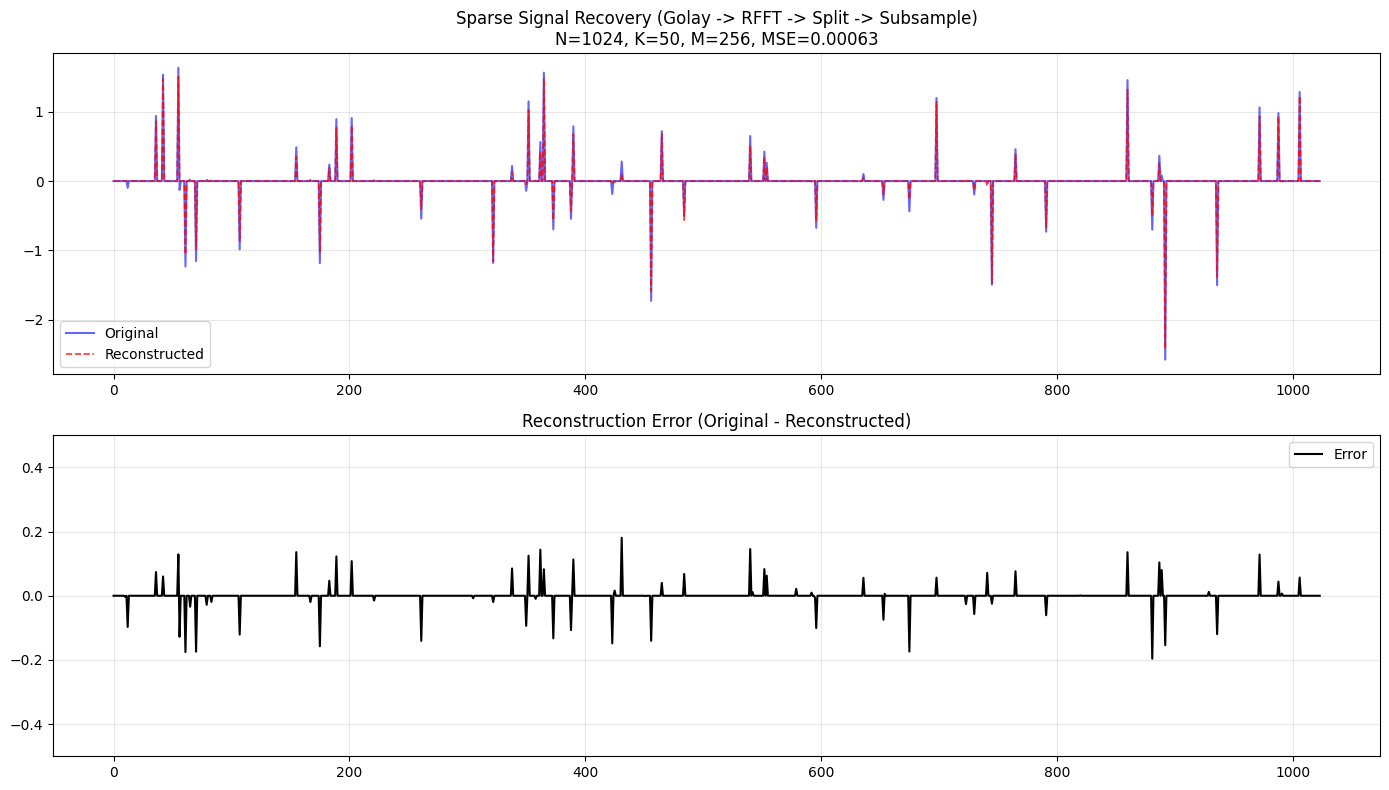

In [20]:
import torch
import torch.fft
import math
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Golay 序列生成 (和你提供的一致)
# ==========================================
def generate_golay_sequence(n):
    if n <= 0: return torch.tensor([])
    exponent = math.ceil(math.log2(n))
    N = 2 ** int(exponent)

    def _recursive(k):
        if k == 1: 
            return torch.tensor([1.]), torch.tensor([1.])
        a, b = _recursive(k // 2)
        return torch.cat([a, b]), torch.cat([a, -b])

    full_seq, _ = _recursive(N)
    return full_seq[:n]

# ==========================================
# 2. 压缩感知算子: Golay + RFFT + Real/Imag Split
# ==========================================
class CS_Operator_RFFT_Real:
    def __init__(self, n, m, device='cpu'):
        self.n = n # 原始长度 (e.g. 1024)
        self.m = m # 测量长度 (e.g. 256)
        self.device = device
        
        # 1. Golay 序列
        self.golay = generate_golay_sequence(n).to(device)
        
        # 2. 计算 RFFT 后的维度
        # rfft 输出形状为 n // 2 + 1
        self.complex_dim = n // 2 + 1
        # 拼接 real 和 imag 后的总长度
        self.flatten_dim = self.complex_dim * 2
        
        print(f"[Operator Info] Input: {n} -> RFFT Complex: {self.complex_dim} -> Flattened Real: {self.flatten_dim}")
        
        # 3. 生成随机采样掩码 (在 Flatten 后的实数域上采样)
        # 我们从 1026 个实数值中选 m 个
        self.mask_indices = torch.randperm(self.flatten_dim, device=device)[:m]
        
    def forward(self, x):
        """
        压缩过程: x (实数) -> y (实数)
        """
        # 1. Golay 调制
        x_mod = x * self.golay
        
        # 2. RFFT (Real to Complex)
        # norm='ortho' 保证变换近似正交
        x_freq = torch.fft.rfft(x_mod, norm='ortho')
        
        # 3. 拆分实部虚部并拼接 (参考你的 CompressModel)
        # shape: [..., complex_dim] -> [..., complex_dim * 2]
        real_part = x_freq.real
        imag_part = x_freq.imag
        x_flat = torch.cat([real_part, imag_part], dim=-1)
        
        # 4. 下采样 (Selection)
        if x.ndim == 1:
            y = x_flat[self.mask_indices]
        else:
            y = x_flat[:, self.mask_indices]
            
        return y

    def adjoint(self, y):
        """
        伴随算子 (用于重建): y (实数) -> x_hat (实数)
        """
        # 1. 恢复全尺寸的实数向量 (Zero Filling)
        batch_size = y.shape[0] if y.ndim > 1 else 1
        
        if y.ndim == 1:
            x_flat_recon = torch.zeros(self.flatten_dim, dtype=y.dtype, device=self.device)
            x_flat_recon[self.mask_indices] = y
        else:
            x_flat_recon = torch.zeros(batch_size, self.flatten_dim, dtype=y.dtype, device=self.device)
            x_flat_recon[:, self.mask_indices] = y
            
        # 2. 拆解回实部和虚部
        # x_flat 是 [Real | Imag] 拼接的
        # split_size = self.complex_dim
        real_recon = x_flat_recon[..., :self.complex_dim]
        imag_recon = x_flat_recon[..., self.complex_dim:]
        
        # 3. 组合成复数
        x_freq_recon = torch.complex(real_recon, imag_recon)
        
        # 4. IRFFT (Complex to Real)
        # 注意指定输出长度 n，防止奇偶歧义
        x_mod_recon = torch.fft.irfft(x_freq_recon, n=self.n, norm='ortho')
        
        # 5. Golay 解调
        x_recon = x_mod_recon * self.golay
        
        return x_recon

# ==========================================
# 3. ISTA 求解器
# ==========================================
def solve_ista(operator, y, lambda_l1=0.1, n_iters=10000, lr=0.5):
    """
    ISTA: Iterative Soft Thresholding Algorithm
    min ||y - Ax||^2 + lambda ||x||_1
    """
    # 初始化 x
    if y.ndim > 1:
        x = torch.zeros(y.shape[0], operator.n, device=operator.device)
    else:
        x = torch.zeros(operator.n, device=operator.device)
        
    losses = []
    
    for i in range(n_iters):
        # 1. 梯度更新 (Landweber iteration)
        # residual = Ax - y
        # grad = A^T(Ax - y)
        measure_est = operator.forward(x)
        residual = measure_est - y
        grad = operator.adjoint(residual)
        
        z = x - lr * grad
        
        # 2. 软阈值 (Proximal Operator for L1)
        threshold = lambda_l1 * lr
        x = torch.sign(z) * torch.maximum(torch.abs(z) - threshold, torch.tensor(0.0, device=x.device))
        
        if i % 100 == 0:
            loss = 0.5 * torch.norm(residual)**2 + lambda_l1 * torch.norm(x, p=1)
            losses.append(loss.item())
            
    return x, losses

# ==========================================
# 4. 主程序
# ==========================================
def main():
    #torch.manual_seed()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on {device}")
    
    # --- 参数 ---
    N = 1024        # 信号长度
    K = 50          # 稀疏度
    M = 256         # 采样点数 (实数) -> 压缩率 25%
    
    # --- 1. 生成稀疏信号 ---
    x_gt = torch.zeros(N, device=device)
    indices = torch.randperm(N)[:K]
    values = torch.randn(K, device=device)
    x_gt[indices] = values
    
    print(f"原始信号: N={N}, K={K}")
    print(f"测量次数: M={M} (压缩比 {N/M:.1f}x)")
    
    # --- 2. 采样 (Encoding) ---
    cs_op = CS_Operator_RFFT_Real(N, M, device)
    y = cs_op.forward(x_gt)
    
    print(f"测量值 y shape: {y.shape} (纯实数)")
    
    # --- 3. 重建 (Decoding) ---
    print("开始 ISTA 重建...")
    # lambda_l1 控制稀疏度惩罚，lr 控制步长
    x_recon, loss_hist = solve_ista(cs_op, y, lambda_l1=0.02, n_iters=3000, lr=0.9)
    
    # --- 4. 结果分析 ---
    mse = torch.mean((x_gt - x_recon)**2).item()
    print(f"重建 MSE: {mse:.8f}")
    
    # --- 5. 绘图 ---
    x_gt_np = x_gt.cpu().numpy()
    x_recon_np = x_recon.cpu().numpy()
    
    plt.figure(figsize=(14, 8))
    
    # 子图1: 原始 vs 重建
    plt.subplot(2, 1, 1)
    plt.title(f"Sparse Signal Recovery (Golay -> RFFT -> Split -> Subsample)\nN={N}, K={K}, M={M}, MSE={mse:.5f}")
    plt.plot(x_gt_np, 'b', label='Original', alpha=0.6, linewidth=1.5)
    plt.plot(x_recon_np, 'r--', label='Reconstructed', alpha=0.8, linewidth=1.2)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 误差
    plt.subplot(2, 1, 2)
    plt.title("Reconstruction Error (Original - Reconstructed)")
    plt.plot(x_gt_np - x_recon_np, 'k', label='Error')
    plt.ylim([-0.5, 0.5]) # 固定一下范围看清噪声
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

In [195]:
import torch
import torch.fft
import math
import time
import numpy as np

# ==========================================
# 1. Golay 序列生成器 (支持任意长度截断)
# ==========================================
def generate_golay_sequence(n, device='cpu'):
    """生成长度为 n 的 Golay 序列 (+1/-1)"""
    if n <= 0: return torch.tensor([], device=device)
    
    # 向上取整到最近的 2^k
    exponent = math.ceil(math.log2(n))
    N = 2 ** int(exponent)

    def _recursive(k):
        if k == 1: 
            return torch.tensor([1.], device=device), torch.tensor([1.], device=device)
        a, b = _recursive(k // 2)
        return torch.cat([a, b]), torch.cat([a, -b])

    full_seq, _ = _recursive(N)
    return full_seq[:n]

# ==========================================
# 2. 两种变换层的实现
# ==========================================

class RFFT_Layer(torch.nn.Module):
    """基于 RFFT 的混合层"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        # 1. RFFT (实数 -> 复数)
        # norm='ortho' 保持能量
        x_freq = torch.fft.rfft(x, dim=-1, norm='ortho')
        
        # 2. 拼接实部虚部 (复数 -> 实数)
        # 这一步是为了模拟真实使用场景，必须包含在耗时里
        x_out = torch.cat([x_freq.real, x_freq.imag], dim=-1)
        
        # 3. 截断/对齐到原始维度
        return x_out[..., :self.dim]

class Block_FWHT_Layer(torch.nn.Module):
    """基于分块 FWHT 的混合层"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        # 寻找最大的 2^k 因子
        self.sub_dim = 1
        temp = dim
        while temp % 2 == 0:
            self.sub_dim *= 2
            temp //= 2
        self.num_blocks = dim // self.sub_dim
        
        # 如果无法分解（比如素数），则 sub_dim=1，这会变得极慢，这里假设能分解
        
    def forward(self, x):
        # 1. Reshape 分块
        B, N = x.shape
        x = x.view(B, self.num_blocks, self.sub_dim)
        
        # 2. 核心 FWHT (非递归 Butterfly 实现)
        # 这种写法减少了 Python 递归开销
        h = x
        h_dim = 1
        n = self.sub_dim
        
        # 归一化因子
        scale = 1.0 / math.sqrt(n)
        
        while h_dim < n:
            h = h.view(B, self.num_blocks, n // (2 * h_dim), 2, h_dim)
            a = h[..., 0, :]
            b = h[..., 1, :]
            h = torch.cat([a + b, a - b], dim=-1)
            h_dim *= 2
            
        h = h.view(B, N)
        return h * scale

# ==========================================
# 3. 基准测试工具 (Benchmark)
# ==========================================
def benchmark(model, x, loops=1000, desc="Model"):
    device = x.device
    model.eval()
    
    # 预热 (Warmup)
    for _ in range(100):
        _ = model(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    # 计时
    start = time.time()
    for _ in range(loops):
        _ = model(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    
    avg_time = (end - start) / loops * 1000 # ms
    print(f"[{desc}] 平均耗时: {avg_time:.4f} ms")
    return avg_time

# ==========================================
# 4. 主运行
# ==========================================
def main():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Testing on GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Testing on CPU (注意：CPU上结果可能不同)")

    # --- 设置参数 ---
    BATCH_SIZE = 256
    DIMS = [192, 384, 768, 1024] # Tiny, Small, Base, Standard 2^k
    LOOPS = 2000

    print(f"Batch Size: {BATCH_SIZE}, Loops: {LOOPS}\n")

    for dim in DIMS:
        print(f"--- Dimension: {dim} ---")
        x = torch.randn(BATCH_SIZE, dim, device=device)
        
        # 1. 实例化模型
        rfft_layer = RFFT_Layer(dim).to(device)
        fwht_layer = Block_FWHT_Layer(dim).to(device)
        
        # 2. 打印 FWHT 分块信息
        print(f"FWHT Strategy: {fwht_layer.num_blocks} blocks of size {fwht_layer.sub_dim}")
        
        # 3. 运行测试
        t_rfft = benchmark(rfft_layer, x, loops=LOOPS, desc="RFFT (Torch)")
        t_fwht = benchmark(fwht_layer, x, loops=LOOPS, desc="FWHT (Block)")
        
        # 4. 结论
        ratio = t_fwht / t_rfft
        winner = "RFFT" if t_rfft < t_fwht else "FWHT"
        print(f"-> {winner} is faster (Ratio: {ratio:.2f}x)\n")

if __name__ == '__main__':
    main()

Testing on CPU (注意：CPU上结果可能不同)
Batch Size: 256, Loops: 2000

--- Dimension: 192 ---
FWHT Strategy: 3 blocks of size 64
[RFFT (Torch)] 平均耗时: 0.0592 ms
[FWHT (Block)] 平均耗时: 0.2567 ms
-> RFFT is faster (Ratio: 4.34x)

--- Dimension: 384 ---
FWHT Strategy: 3 blocks of size 128
[RFFT (Torch)] 平均耗时: 0.1532 ms
[FWHT (Block)] 平均耗时: 0.3420 ms
-> RFFT is faster (Ratio: 2.23x)

--- Dimension: 768 ---
FWHT Strategy: 3 blocks of size 256
[RFFT (Torch)] 平均耗时: 0.1965 ms
[FWHT (Block)] 平均耗时: 0.4966 ms
-> RFFT is faster (Ratio: 2.53x)

--- Dimension: 1024 ---
FWHT Strategy: 1 blocks of size 1024
[RFFT (Torch)] 平均耗时: 0.2532 ms
[FWHT (Block)] 平均耗时: 0.7198 ms
-> RFFT is faster (Ratio: 2.84x)



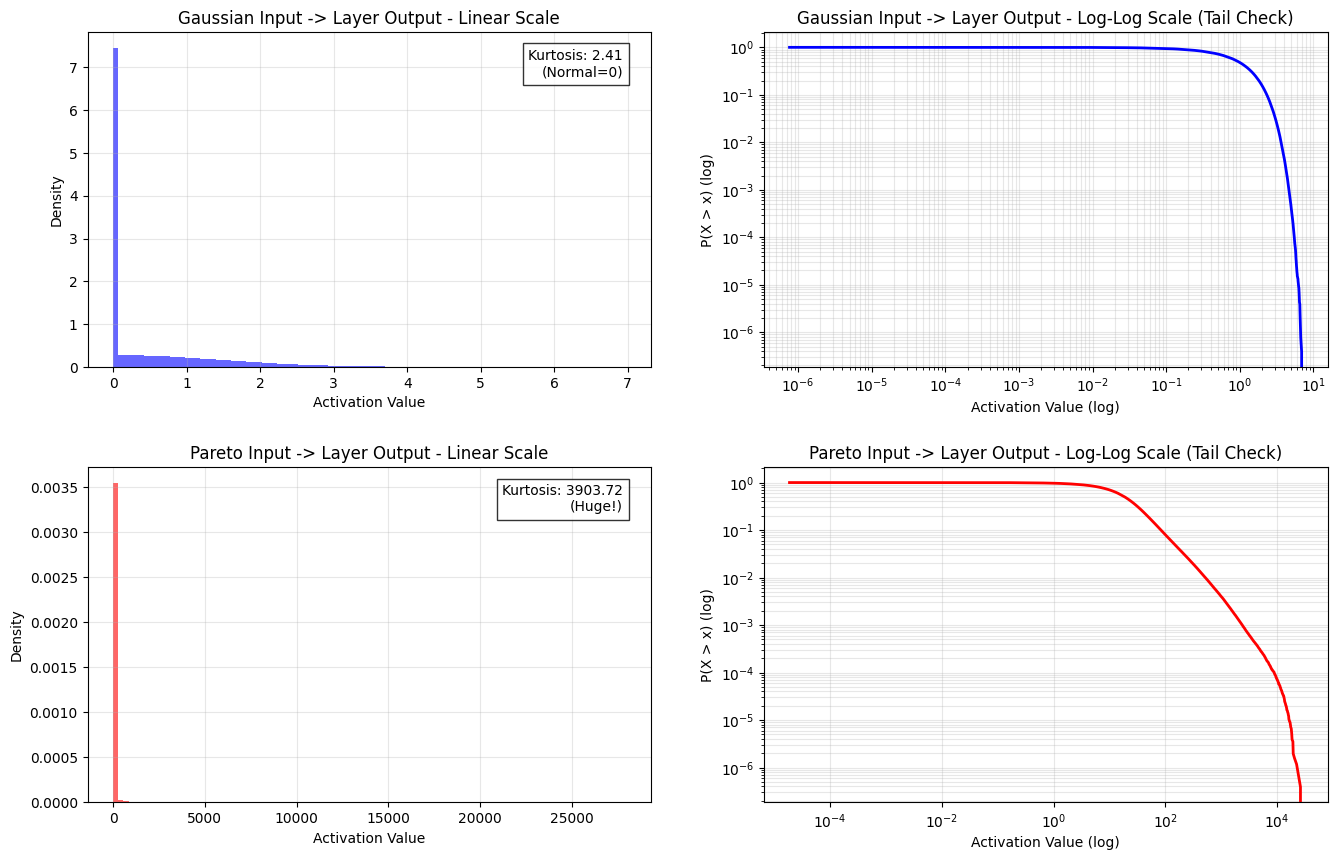

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 设置随机种子以保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

def generate_data(batch_size, input_dim, dist_type='gaussian', alpha=1.5):
    """
    生成不同分布的数据
    alpha: 帕累托分布的形状参数 (Tail Index). alpha越小，尾巴越重。
           通常 alpha < 2 时方差无限大，表现出极强的长尾特性。
    """
    if dist_type == 'gaussian':
        # 标准高斯分布 N(0, 1)
        return torch.randn(batch_size, input_dim)
    elif dist_type == 'pareto':
        # PyTorch的Pareto生成的是 x >= 1 的分布
        m = torch.distributions.Pareto(scale=1.0, alpha=alpha)
        data = m.sample((batch_size, input_dim))
        
        # 为了更接近真实神经网络输入，我们将其中心化（减去中位数或均值）
        # 让它有正有负，但保留单侧的长尾特性
        # 注意：对于 alpha < 1，均值是无限的，所以这里简单减去 1 让它从 0 开始
        return data - 1.0 
    else:
        raise ValueError("Unknown distribution type")

def run_simulation():
    # --- 1. 配置参数 ---
    BATCH_SIZE = 5000  # 样本量大一些以便观察分布
    INPUT_DIM = 1024   # 输入维度
    HIDDEN_DIM = 1024  # 隐藏层维度
    
    # 定义层：Linear -> BN -> ReLU
    layer = nn.Sequential(
        nn.Linear(INPUT_DIM, HIDDEN_DIM, bias=False), # 无偏置，纯线性组合
        nn.BatchNorm1d(HIDDEN_DIM),
        nn.ReLU()
    )
    
    # 初始化权重 (Kaiming Init) - 这是目前的标准做法
    nn.init.kaiming_normal_(layer[0].weight, mode='fan_in', nonlinearity='relu')
    
    # 设为评估模式 (固定 BN 的 mean/var)
    layer.eval()

    # --- 2. 生成数据 ---
    # A. 高斯输入
    x_gaussian = generate_data(BATCH_SIZE, INPUT_DIM, 'gaussian')
    # B. 长尾输入 (Pareto, alpha=1.2, 非常重的尾巴)
    x_pareto = generate_data(BATCH_SIZE, INPUT_DIM, 'pareto', alpha=1.2)

    # --- 3. 前向传播 ---
    with torch.no_grad():
        out_gaussian = layer(x_gaussian)
        out_pareto = layer(x_pareto)

    # 展平数据以便画图 (我们关注所有激活值的总体分布)
    flat_gaussian_in = x_gaussian.numpy().flatten()
    flat_pareto_in = x_pareto.numpy().flatten()
    
    flat_gaussian_out = out_gaussian.numpy().flatten()
    flat_pareto_out = out_pareto.numpy().flatten()

    # --- 4. 可视化对比 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.3)

    # 辅助函数：绘制直方图和对数图
    def plot_dist(ax_hist, ax_log, data, title_prefix, color):
        # 1. 线性直方图
        ax_hist.hist(data, bins=100, density=True, alpha=0.6, color=color, label='Histogram')
        ax_hist.set_title(f"{title_prefix} - Linear Scale")
        ax_hist.set_xlabel("Activation Value")
        ax_hist.set_ylabel("Density")
        ax_hist.grid(True, alpha=0.3)
        
        # 2. Log-Log Plot (互补累积分布函数 CCDF: P(X > x))
        # 这是验证幂律/长尾分布的金标准。如果是直线，则是幂律分布。
        
        # 只取正值部分进行 Log-Log 绘图 (因为 ReLU 后只有正值，且长尾通常关注大概率的大值)
        data_pos = data[data > 0]
        sorted_data = np.sort(data_pos)
        y = 1. * np.arange(len(sorted_data))[::-1] / len(sorted_data)
        
        ax_log.loglog(sorted_data, y, color=color, linewidth=2, label='CCDF (Log-Log)')
        ax_log.set_title(f"{title_prefix} - Log-Log Scale (Tail Check)")
        ax_log.set_xlabel("Activation Value (log)")
        ax_log.set_ylabel("P(X > x) (log)")
        ax_log.grid(True, which="both", ls="-", alpha=0.3)

    # 绘制高斯组
    plot_dist(axes[0][0], axes[0][1], flat_gaussian_out, "Gaussian Input -> Layer Output", 'blue')
    
    # 绘制帕累托组
    plot_dist(axes[1][0], axes[1][1], flat_pareto_out, "Pareto Input -> Layer Output", 'red')

    # 添加峰度 (Kurtosis) 标注 - 峰度越高，尾巴越重
    k_gauss = stats.kurtosis(flat_gaussian_out)
    k_pareto = stats.kurtosis(flat_pareto_out)
    
    axes[0][0].text(0.95, 0.95, f'Kurtosis: {k_gauss:.2f}\n(Normal=0)', 
                    transform=axes[0][0].transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    axes[1][0].text(0.95, 0.95, f'Kurtosis: {k_pareto:.2f}\n(Huge!)', 
                    transform=axes[1][0].transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

if __name__ == "__main__":
    run_simulation()

In [194]:
import torch
import torch.nn as nn
import math

def generate_golay_sequence(n):
    if n <= 0: return torch.tensor([])
    exponent = math.ceil(math.log2(n))
    N = 2 ** int(exponent)
    def _recursive(k):
        if k == 1: return torch.tensor([1.]), torch.tensor([1.])
        a, b = _recursive(k // 2)
        return torch.cat([a, b]), torch.cat([a, -b])
    return _recursive(N)[0][:n]

def fwht(x):
    # 简化的 Block FWHT 模拟
    # 这里假设 x 是 2 的幂次，或者已经处理过
    n = x.shape[-1]
    if (n & (n-1)) != 0: # 简单的 Padding 处理 demo
        pad = 2**math.ceil(math.log2(n)) - n
        x = torch.nn.functional.pad(x, (0, pad))
    
    # 快速哈达玛变换
    h = x.clone()
    h_dim = 1
    while h_dim < h.shape[-1]:
        h = h.view(*h.shape[:-1], -1, 2, h_dim)
        a, b = h[..., 0, :], h[..., 1, :]
        h = torch.cat([a+b, a-b], dim=-1)
        h_dim *= 2
    h = h.view(*x.shape) / math.sqrt(h.shape[-1]) # 归一化
    
    if (n & (n-1)) != 0:
        h = h[..., :n] # 截断回原始维度
    return h

def main():
    torch.manual_seed(42)
    dim = 768
    
    # 1. 准备数据
    x = torch.randn(1, dim)*10 # 输入
    w = torch.randn(dim, dim) # 权重矩阵 (模拟 Linear 层)
    golay = generate_golay_sequence(dim)
    
    # 2. 计算 RMS Norm
    rms = torch.sqrt(x.pow(2).mean() + 1e-6)
    x_norm = x / rms
    
    # --- 实验 1: 你的两种缩放方案对比 ---
    # 方案 A: 保持归一化
    y_A = fwht(x_norm * golay)
    # 方案 B: 乘回系数 (相当于 fwht(x * golay))
    y_B = y_A * rms 
    
    print(f"原始 x 范数: {x.norm().item():.4f}")
    print(f"方案 A (Norm) 范数: {y_A.norm().item():.4f}")
    print(f"方案 B (Rescale) 范数: {y_B.norm().item():.4f}")
    print("-> 结论: 方案 B 把能量还原了，方案 A 保持单位能量。\n")
    
    # --- 实验 2: 双侧变换 (Dual Transform) 验证 ---
    print("验证: <Transform(x), Transform(w)> == <x, w> ?")
    
    # 原始 Linear
    # y = x @ w.T
    out_original = torch.matmul(x, w.T)
    
    # 变换域 Linear
    # 1. 对 x 变换
    x_hat = fwht(x * golay)
    # 2. 对 w 的每一行变换 (注意是对 weights 进行同样的变换)
    w_hat = fwht(w * golay) # 广播乘法
    
    # 3. 在变换域做点积
    out_transformed = torch.matmul(x_hat, w_hat.T)
    
    # 比较
    diff = torch.abs(out_original - out_transformed).mean()
    relative_err = diff / out_original.abs().mean()
    
    print(f"原始输出均值: {out_original.mean().item():.4f}")
    print(f"变换输出均值: {out_transformed.mean().item():.4f}")
    print(f"相对误差: {relative_err.item():.8f}")
    
    if relative_err < 1e-5:
        print("✅ 验证成功: 全维度下，双侧变换在数学上等价于原始点积。")
        print("   (这意味着除非你做下采样/压缩，否则这么做只是增加了计算量)")
    else:
        print("❌ 误差较大，可能是 FWHT 的 Padding 导致了部分能量泄露")

if __name__ == '__main__':
    main()

原始 x 范数: 276.7250
方案 A (Norm) 范数: 27.7128
方案 B (Rescale) 范数: 276.7250
-> 结论: 方案 B 把能量还原了，方案 A 保持单位能量。

验证: <Transform(x), Transform(w)> == <x, w> ?
原始输出均值: 3.8099
变换输出均值: 3.8099
相对误差: 0.00000020
✅ 验证成功: 全维度下，双侧变换在数学上等价于原始点积。
   (这意味着除非你做下采样/压缩，否则这么做只是增加了计算量)


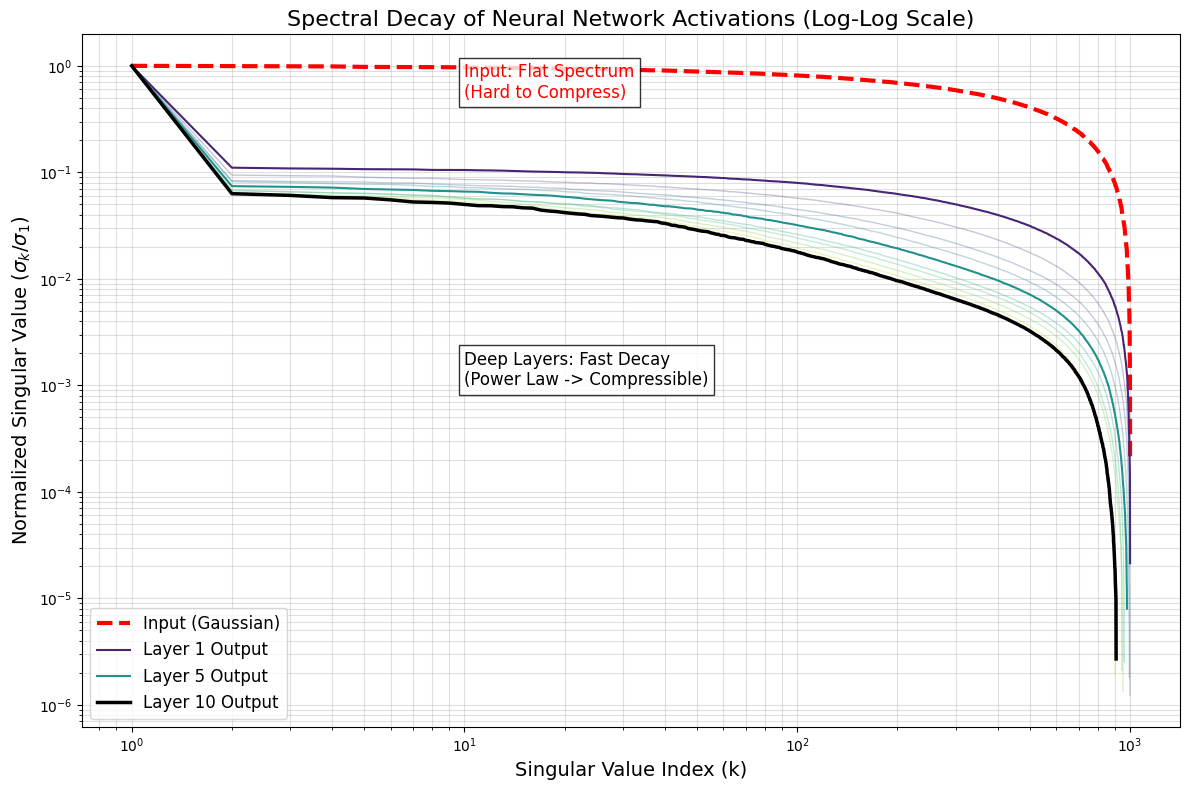

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

def analyze_spectral_decay():
    # --- 1. 参数设置 ---
    BATCH_SIZE = 1000   # 样本数 (行)
    DIM = 1000          # 神经元数 (列)
    DEPTH = 10          # 网络深度
    
    # --- 2. 准备数据 ---
    # 输入：完全随机的高斯噪声，模拟满秩(Full Rank)信号
    # 理论上它的奇异值应该是非常平缓的（服从 Marchenko-Pastur 分布）
    x = torch.randn(BATCH_SIZE, DIM)
    
    # --- 3. 构建网络 ---
    # 我们使用一个深层的 MLP，即使是随机初始化的网络，
    # 也会表现出“秩坍塌”(Rank Collapse) 或 谱衰减现象。
    layers = []
    for _ in range(DEPTH):
        layers.append(nn.Linear(DIM, DIM))
        layers.append(nn.ReLU()) # ReLU 是非线性的关键，它会切断空间
    
    model = nn.Sequential(*layers)
    
    # 初始化：使用标准的 Kaiming 初始化
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    # --- 4. 提取各层的激活值并计算 SVD ---
    singular_values_dict = {}
    
    # 4.1. 计算基准 (纯随机矩阵) 的奇异值
    # 归一化一下以便对比趋势
    _, S_input, _ = torch.linalg.svd(x)
    singular_values_dict['Input (Gaussian)'] = S_input.numpy() / S_input.numpy()[0]

    # 4.2. 逐层前向传播并记录
    current_act = x
    with torch.no_grad():
        for i, layer in enumerate(model):
            current_act = layer(current_act)
            
            # 我们只在经过 ReLU 之后记录（每隔两步：Linear->ReLU）
            if isinstance(layer, nn.ReLU):
                # 记录第几层 ReLU 的输出
                layer_idx = (i + 1) // 2
                
                # 计算奇异值分解 (SVD)
                # A = U * S * V^T, 我们只需要 S (奇异值向量)
                _, S, _ = torch.linalg.svd(current_act)
                
                # 归一化 (除以最大奇异值)，这样我们只看衰减率，不看绝对大小
                # 添加一个小常数防止除零（虽然一般不会）
                if S[0] > 0:
                    S_norm = S.numpy() / S[0]
                else:
                    S_norm = S.numpy()
                
                singular_values_dict[f'Layer {layer_idx} Output'] = S_norm

    # --- 5. 可视化 (Log-Log Plot) ---
    plt.figure(figsize=(12, 8))
    
    # 颜色映射
    colors = plt.cm.viridis(np.linspace(0, 1, len(singular_values_dict)))
    
    for idx, (name, s_vals) in enumerate(singular_values_dict.items()):
        # 排除 0 值以避免 log 报错
        s_vals = s_vals[s_vals > 1e-6]
        
        # 这里的 x 轴是奇异值的索引 (1st, 2nd, 3rd dominant component...)
        indices = np.arange(1, len(s_vals) + 1)
        
        # 绘制 Log-Log 曲线
        if name == 'Input (Gaussian)':
            plt.loglog(indices, s_vals, label=name, color='red', linewidth=3, linestyle='--')
        elif 'Layer 10' in name: # 突出显示最后一层
            plt.loglog(indices, s_vals, label=name, color='black', linewidth=2.5)
        elif 'Layer 1 ' in name or 'Layer 5' in name: # 选几层画，避免太乱
            plt.loglog(indices, s_vals, label=name, color=colors[idx], linewidth=1.5)
        else:
            # 中间层画淡一点
            plt.loglog(indices, s_vals, color=colors[idx], alpha=0.3, linewidth=1)

    plt.title('Spectral Decay of Neural Network Activations (Log-Log Scale)', fontsize=16)
    plt.xlabel('Singular Value Index (k)', fontsize=14)
    plt.ylabel('Normalized Singular Value ($\sigma_k / \sigma_1$)', fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.4)
    plt.legend(fontsize=12)
    
    # 添加注释解释
    plt.text(10, 0.5, "Input: Flat Spectrum\n(Hard to Compress)", 
             color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.text(10, 0.001, "Deep Layers: Fast Decay\n(Power Law -> Compressible)", 
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_spectral_decay()

矩阵 X 构建完成。维度: (1000, 1000)
验证 X 的奇异值是否服从幂律分布...


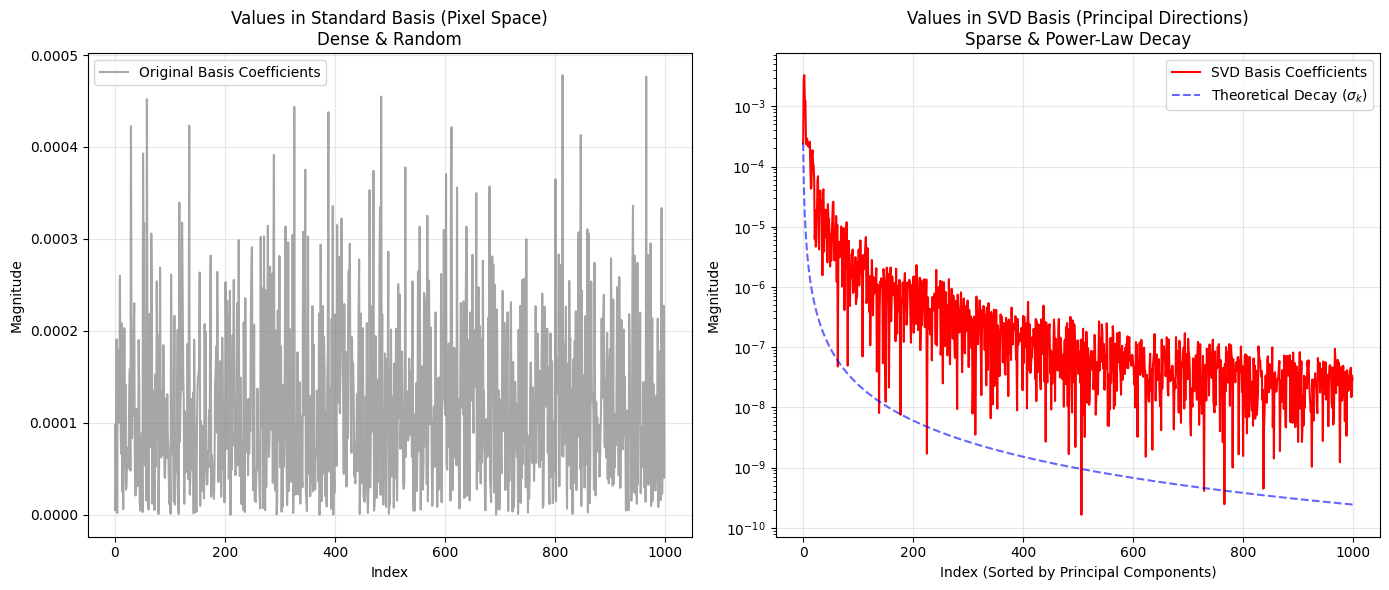


--- 稀疏性度量 (L1/L2 Ratio) ---
原始空间: 25.08 (数值较大，说明能量分散)
SVD 空间: 2.66 (数值较小，说明能量集中，更加稀疏)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 设置实验参数
N = 1000    # 矩阵维度 (N x N)
Rank = 1000 # 满秩，但是奇异值衰减
decay_power = 2.0 # 幂律衰减系数 (alpha)，越大衰减越快

# 2. 构造具有特定奇异值衰减的矩阵 X
# 奇异值 sigma_k ~ 1 / k^alpha
k = np.arange(1, Rank + 1)
singular_values = 1 / (k ** decay_power)

# 生成随机正交矩阵 U 和 V (模拟任意的旋转)
# 使用 QR 分解生成正交基
np.random.seed(42)
U_rand, _ = np.linalg.qr(np.random.randn(N, N))
V_rand, _ = np.linalg.qr(np.random.randn(N, N))

# 构造矩阵 X = U * Sigma * V^T
Sigma_matrix = np.diag(singular_values)
X = U_rand @ Sigma_matrix @ V_rand.T

print(f"矩阵 X 构建完成。维度: {X.shape}")
print("验证 X 的奇异值是否服从幂律分布...")

# 3. 验证假设：基变换
# 我们取 X 的任意一列数据 x_sample
col_idx = 10 # 随机选第10列
x_sample = X[:, col_idx]

# A. 在原始基 (Identity Basis) 下的系数
# 就是 x_sample 本身的值
coeffs_standard = np.abs(x_sample)

# B. 在 SVD 左奇异向量基 (U) 下的系数
# 变换公式: alpha = U^T * x
# 注意：这里的 U 必须是 X 真实的左奇异矩阵，在我们的构造中就是 U_rand
coeffs_svd = np.abs(U_rand.T @ x_sample)

# 4. 可视化对比
plt.figure(figsize=(14, 6))

# 子图1: 原始基下的系数分布
plt.subplot(1, 2, 1)
plt.plot(coeffs_standard, color='gray', alpha=0.7, label='Original Basis Coefficients')
plt.title("Values in Standard Basis (Pixel Space)\nDense & Random", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2: SVD基下的系数分布 (验证你的猜想)
plt.subplot(1, 2, 2)
plt.plot(coeffs_svd, color='red', linewidth=1.5, label='SVD Basis Coefficients')
# 叠加理论衰减曲线 (缩放以匹配量级)
scale_factor = coeffs_svd[0] / singular_values[0] 
plt.plot(singular_values * scale_factor, 'b--', linewidth=1.5, alpha=0.6, label=r'Theoretical Decay ($\sigma_k$)')

plt.title("Values in SVD Basis (Principal Directions)\nSparse & Power-Law Decay", fontsize=12)
plt.xlabel("Index (Sorted by Principal Components)")
plt.ylabel("Magnitude")
plt.yscale('log') # 使用对数坐标展示幂律
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. 定量分析稀疏性 (L1/L2 比率，越小越稀疏)
def sparsity_measure(vec):
    return np.linalg.norm(vec, 1) / np.linalg.norm(vec, 2)

s_std = sparsity_measure(x_sample)
s_svd = sparsity_measure(coeffs_svd)

print(f"\n--- 稀疏性度量 (L1/L2 Ratio) ---")
print(f"原始空间: {s_std:.2f} (数值较大，说明能量分散)")
print(f"SVD 空间: {s_svd:.2f} (数值较小，说明能量集中，更加稀疏)")

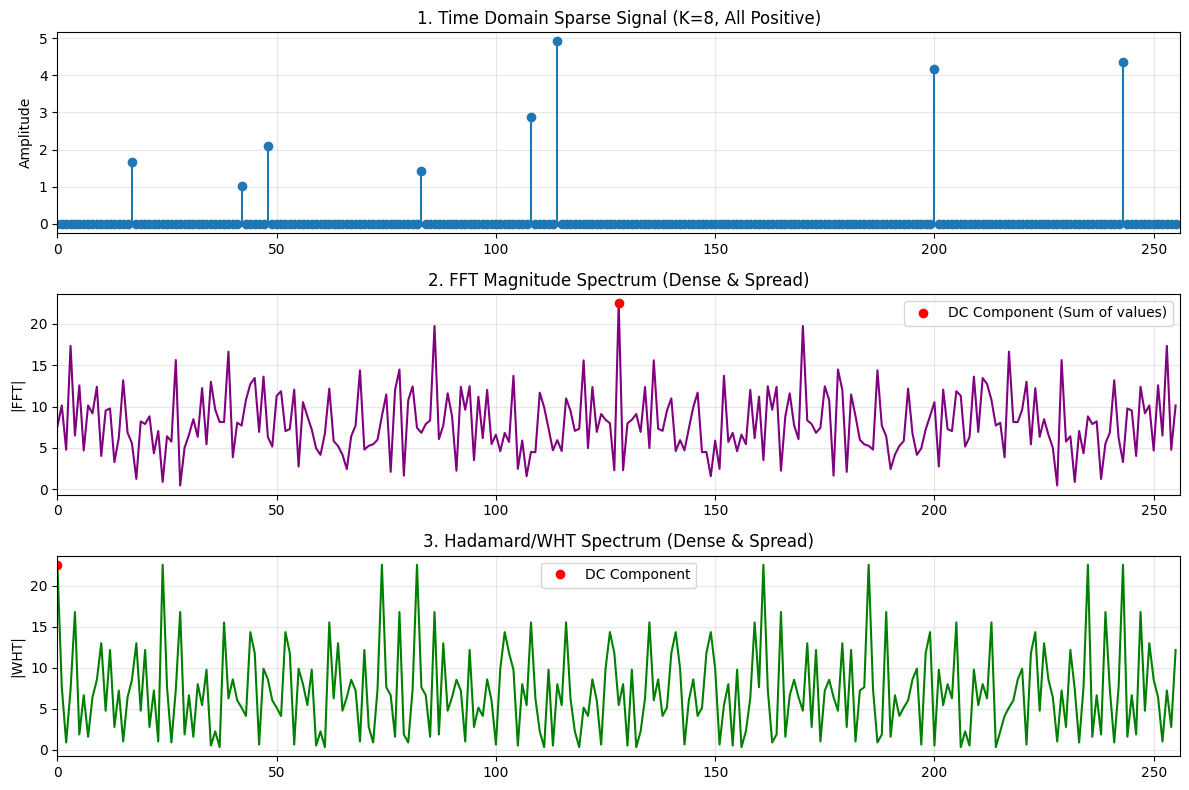

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hadamard

# 1. 设置参数
N = 256  # 信号总长度 (必须是2的幂次方以便做Hadamard变换)
K = 8    # 稀疏度 (只有8个非零点)

# 2. 生成稀疏且为正的信号
# 初始化全0
x = np.zeros(N)
# 随机选择K个位置
indices = np.random.choice(N, K, replace=False)
# 赋值为正数 (例如 1 到 5 之间的随机数)
x[indices] = np.random.uniform(1, 5, K)

# 3. 计算 FFT 频谱
# 使用 fftshift 把 0 频率移到中心，方便观察
x_fft = np.fft.fft(x)
x_fft_mag = np.abs(np.fft.fftshift(x_fft))

# 4. 计算 Hadamard (WHT) 频谱
# 生成 Hadamard 矩阵
H = hadamard(N)
# 计算变换 (注意：标准的 WHT 可能没有归一化，这里我们只看形态)
x_wht = np.dot(H, x)
x_wht_mag = np.abs(x_wht)

# 5. 绘图对比
plt.figure(figsize=(12, 8))

# 子图1: 原始稀疏信号
plt.subplot(3, 1, 1)
plt.stem(x, basefmt=" ")
plt.title(f'1. Time Domain Sparse Signal (K={K}, All Positive)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, N)
plt.ylabel('Amplitude')

# 子图2: FFT 幅度谱
plt.subplot(3, 1, 2)
# 标记出 DC 分量
center_idx = N // 2
plt.plot(x_fft_mag, color='purple')
plt.plot(center_idx, x_fft_mag[center_idx], 'ro', label='DC Component (Sum of values)')
plt.title('2. FFT Magnitude Spectrum (Dense & Spread)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, N)
plt.ylabel('|FFT|')

# 子图3: Hadamard 频谱
plt.subplot(3, 1, 3)
plt.plot(x_wht_mag, color='green')
plt.plot(0, x_wht_mag[0], 'ro', label='DC Component')
plt.title('3. Hadamard/WHT Spectrum (Dense & Spread)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, N)
plt.ylabel('|WHT|')

plt.tight_layout()
plt.show()

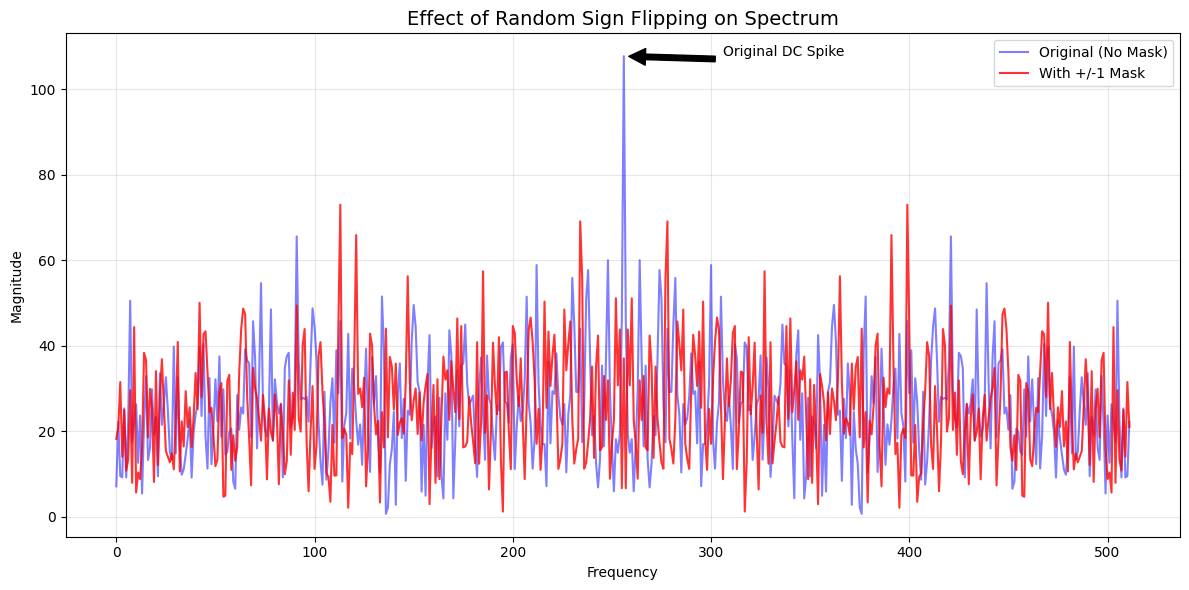

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 设置参数
N = 512
K = 15  # 稀疏度

# 2. 生成稀疏且为正的信号
x = np.zeros(N)
indices = np.random.choice(N, K, replace=False)
x[indices] = np.random.uniform(5, 10, K) # 较大的正数

# 3. 生成 +/- 1 Mask (Rademacher 序列)
mask = np.random.choice([1, -1], N)
x_masked = x * mask

# 4. 计算 FFT
# 情况A: 原始信号
fft_original = np.abs(np.fft.fftshift(np.fft.fft(x)))

# 情况B: 加 Mask 后的信号
fft_masked = np.abs(np.fft.fftshift(np.fft.fft(x_masked)))

# 5. 绘图对比
plt.figure(figsize=(12, 6))

# 画出 FFT 对比
plt.plot(fft_original, color='blue', alpha=0.5, label='Original (No Mask)')
plt.plot(fft_masked, color='red', alpha=0.8, linewidth=1.5, label='With +/-1 Mask')

# 标注 DC 分量
center = N // 2
plt.annotate('Original DC Spike', xy=(center, fft_original[center]), 
             xytext=(center+50, fft_original[center]),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Effect of Random Sign Flipping on Spectrum', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Magnitude')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

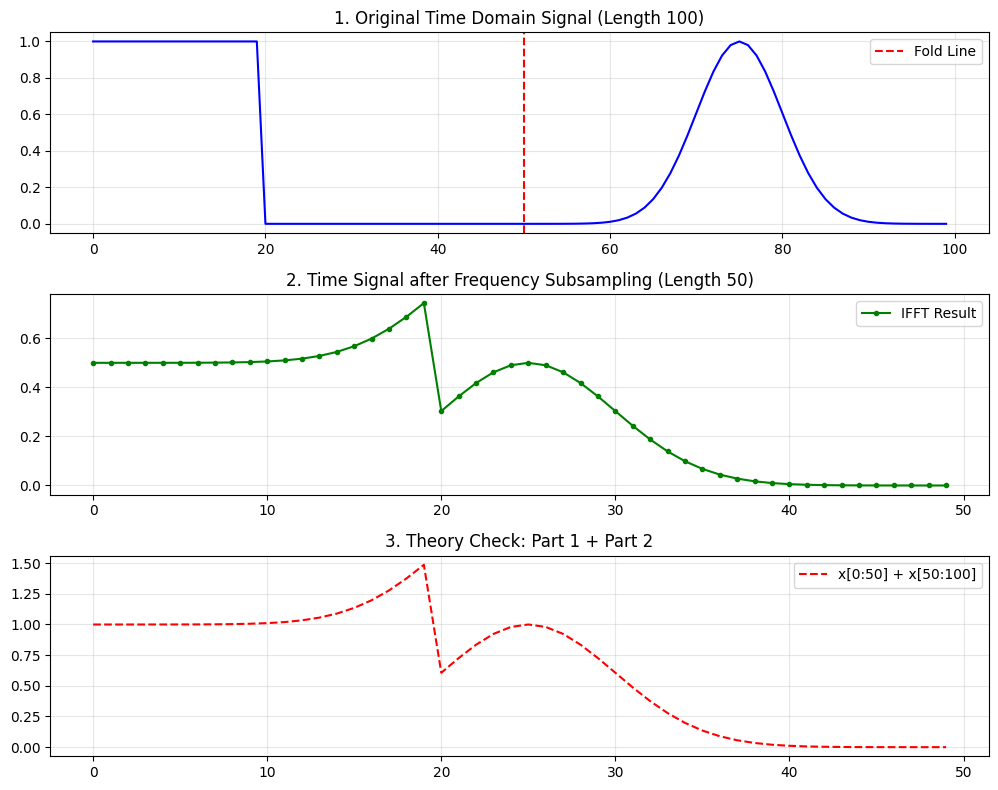

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 制造原始信号 (长度 N=100)
N = 100
n = np.arange(N)
x = np.zeros(N)

# 前半段放一个方波 (0-20)
x[0:20] = 1
# 后半段放一个高斯波 (50-100)
x[50:] = np.exp(-(n[50:] - 75)**2 / 50)

# 2. 计算 FFT
X = np.fft.fft(x)

# 3. 频域均匀下采样 (每隔2个取一个: 0, 2, 4...)
# 这相当于丢弃了所有奇数频率，只保留偶数频率
# 剩下的频谱长度为 N/2 = 50
X_sub = X[::2]

# 4. 逆变换回时域
# 注意：因为频谱只有50个点，IFFT出来的时域信号也只有50个点
x_aliased = np.fft.ifft(X_sub) * 0.5 # 乘0.5是因为FFT能量守恒的系数调整 (丢了一半能量)

# 理论上的折叠结果: 前50个点 + 后50个点
x_folded_theory = x[0:50] + x[50:100]

# 5. 绘图
plt.figure(figsize=(10, 8))

# 原始信号
plt.subplot(3, 1, 1)
plt.title("1. Original Time Domain Signal (Length 100)")
plt.plot(n, x, 'b')
plt.axvline(50, color='r', linestyle='--', label='Fold Line')
plt.legend()
plt.grid(True, alpha=0.3)

# 频域下采样后的时域恢复
plt.subplot(3, 1, 2)
plt.title("2. Time Signal after Frequency Subsampling (Length 50)")
plt.plot(np.abs(x_aliased), 'g', marker='.', label='IFFT Result')
plt.grid(True, alpha=0.3)
plt.legend()

# 理论折叠验证
plt.subplot(3, 1, 3)
plt.title("3. Theory Check: Part 1 + Part 2")
plt.plot(x_folded_theory, 'r--', label='x[0:50] + x[50:100]')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

/Users/sixexamelben/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


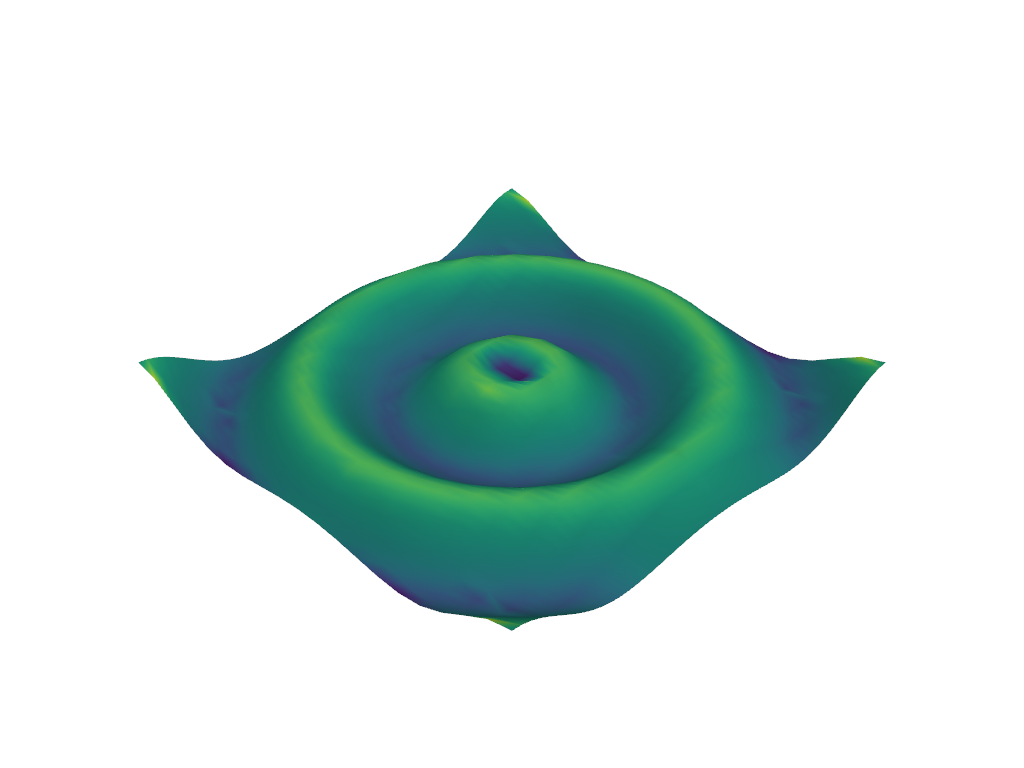

In [ ]:
from __future__ import annotations

import numpy as np
import pyvista as pv

# 1. 生成数据
xrng = np.linspace(-10, 10)
yrng = np.linspace(-10, 10, 20)
x, y = np.meshgrid(xrng, yrng, indexing='ij')
r = np.sqrt(x**2 + y**2)
z = np.sin(r)

# 2. 创建网格
grid = pv.StructuredGrid(x, y, z)

# 3. 绘图：移除所有辅助元素
# show_axes=False  -> 移除左下角的 XYZ 坐标箭头
# show_grid=False  -> 移除包裹物体的刻度网格框 (默认通常是关闭的，这里显式写出以防万一)
# show_edges=True  -> 保留网格线条，看结构更清楚 (可选)
grid.plot_curvature(show_axes=False, show_grid=False, show_edges=False, smooth_shading=True,clim=[-1, 1],show_scalar_bar=False)

/Users/sixexamelben/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


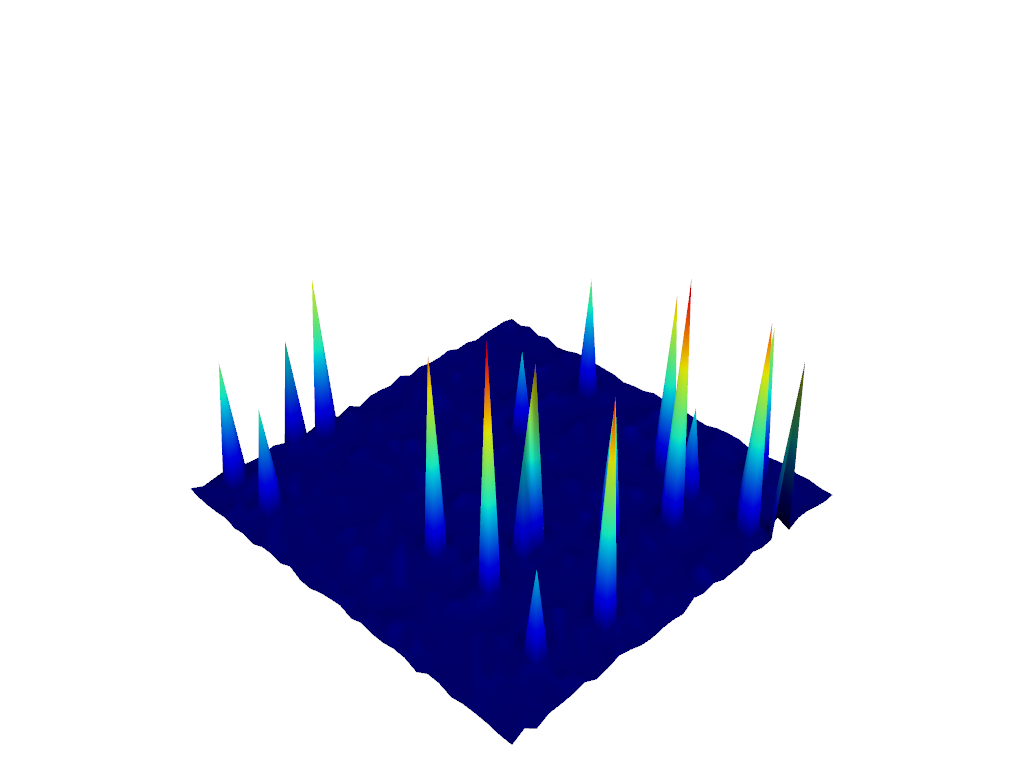

In [ ]:
from __future__ import annotations
import numpy as np
import pyvista as pv

# 1. 生成数据
N = 32
xrng = np.linspace(0, N, N)
yrng = np.linspace(0, N, N)
x, y = np.meshgrid(xrng, yrng, indexing='ij')

# 初始化全0背景
z = np.zeros_like(x)

# --- 随机生成 10 个脉冲 ---
np.random.seed(42)
num_pulses = 20

idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)
amps = np.random.uniform(0.3, 1.0, num_pulses)

z[idx_x, idx_y] = amps

# --- 添加噪声 ---
noise = np.random.normal(0, 0.01, z.shape)
z = z + noise

# 放大数值
z_scaled = z * 20.0

# 2. 创建网格
grid = pv.StructuredGrid(x, y, z_scaled)

# 【关键修正】将 Z 数据绑定给网格，作为上色的依据 (Scalars)
# order='F' 是因为 VTK/PyVista 内部数据排列顺序的要求，与 meshgrid='ij' 对应
grid.point_data["height"] = z_scaled.flatten(order="F")

# 3. 绘图
grid.plot(
    show_axes=False,
    show_grid=False,
    show_edges=False,
    smooth_shading=True,
    # 这里的 clim 决定了颜色的映射范围
    clim=[0, 20], 
    show_scalar_bar=False,
    cmap='jet'  # 现在这个参数会生效了
)

/Users/sixexamelben/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


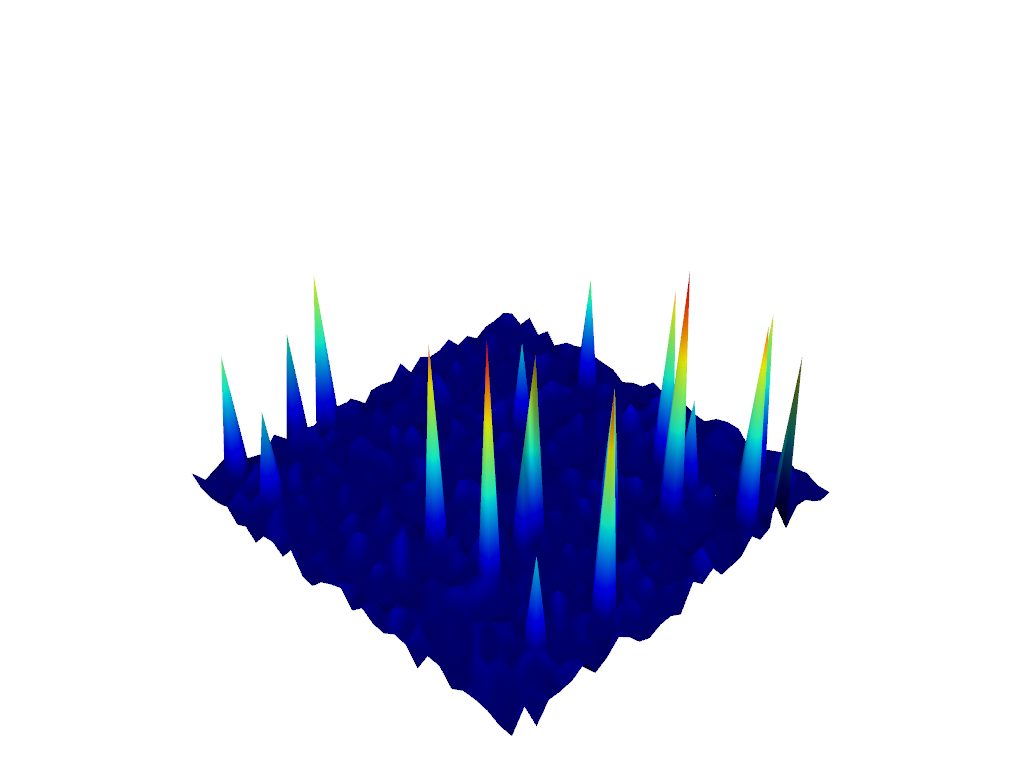

In [1]:
from __future__ import annotations
import numpy as np
import pyvista as pv

# 1. 生成数据
N = 32
xrng = np.linspace(0, N, N)
yrng = np.linspace(0, N, N)
x, y = np.meshgrid(xrng, yrng, indexing='ij')

# 初始化全0背景
z = np.zeros_like(x)

# --- 随机生成 10 个脉冲 ---
np.random.seed(42)
num_pulses = 20

idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)
amps = np.random.uniform(0.3, 1.0, num_pulses)

z[idx_x, idx_y] = amps

# --- 添加噪声 ---
noise = np.random.normal(0, 0.03, z.shape)
z = z + noise

# 放大数值
z_scaled = z * 20.0

# 2. 创建网格
grid = pv.StructuredGrid(x, y, z_scaled)

# 【关键修正】将 Z 数据绑定给网格，作为上色的依据 (Scalars)
# order='F' 是因为 VTK/PyVista 内部数据排列顺序的要求，与 meshgrid='ij' 对应
grid.point_data["height"] = z_scaled.flatten(order="F")

# 3. 绘图
grid.plot(
    show_axes=False,
    show_grid=False,
    show_edges=False,
    smooth_shading=True,
    # 这里的 clim 决定了颜色的映射范围
    clim=[0, 20], 
    show_scalar_bar=False,
    cmap='jet'  # 现在这个参数会生效了
)

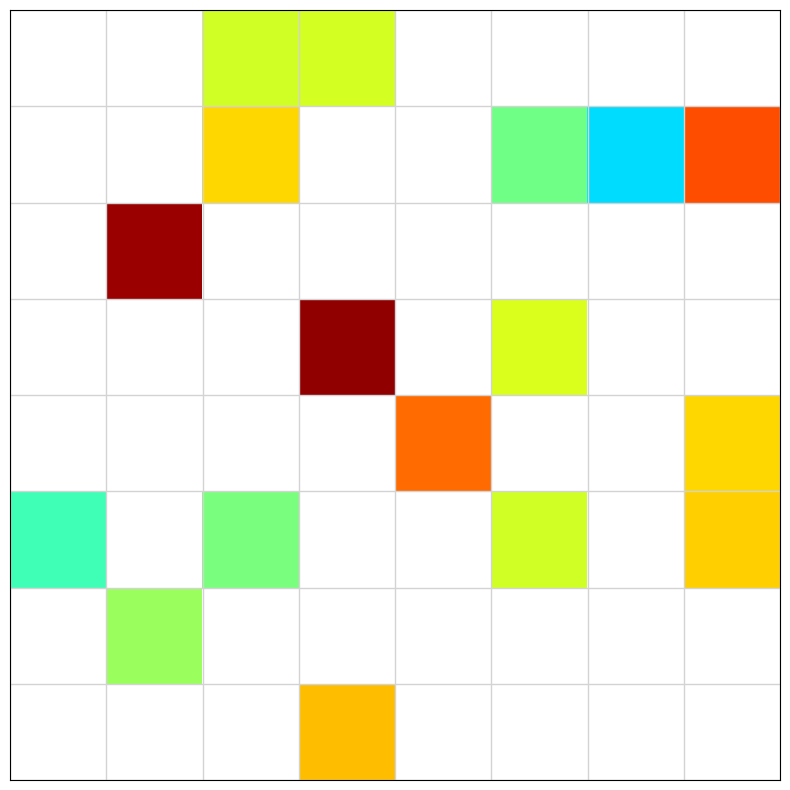

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# ==========================================
# 1. 生成数据 (保持原逻辑不变)
# ==========================================
N = 8
xrng = np.linspace(0, N, N)
yrng = np.linspace(0, N, N)
x, y = np.meshgrid(xrng, yrng, indexing='ij')

# 初始化背景
z = np.zeros_like(x)

# --- 随机生成脉冲 ---
num_pulses = 18
idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)
amps = np.random.uniform(0.3, 1.0, num_pulses)
z[idx_x, idx_y] = amps

# --- 添加噪声 ---
noise = np.random.normal(0, 0.03, z.shape)
z = z + noise

# 放大数值
z_scaled = z * 20.0

# ==========================================
# 2. 绘制带网格的白色背景热力图
# ==========================================
fig, ax = plt.subplots(figsize=(8, 8)) # 使用正方形比例

# 【关键步骤1：实现白色底色】
# 方法：创建一个掩码 (Mask)，把低于某个阈值(比如噪声底噪)的值隐藏掉。
# 这样这些位置就会变成透明，显示出画布的白色背景。
threshold = 2.0  # 阈值：因为信号都在 6.0 以上 (0.3*20)，噪声在 1.0 以下，设 2.0 很安全
z_masked = np.ma.masked_where(z_scaled < threshold, z_scaled)

# 【关键步骤2：绘制】
# 使用 z_masked.T 进行绘制
# vmin, vmax 依然保留，确保脉冲颜色正确
ax.imshow(z_masked.T, cmap='jet', origin='lower', extent=[0, N, 0, N], vmin=0, vmax=20)

# 【关键步骤3：绘制方格网络】
# 设置刻度在整数位置，这样网格线就会画在像素之间
ax.set_xticks(np.arange(0, N + 1, 1))
ax.set_yticks(np.arange(0, N + 1, 1))

# 开启网格，设置颜色为浅灰，线条细一点
ax.grid(which='major', color='lightgray', linestyle='-', linewidth=1)

# 【关键步骤4：去除刻度与多余元素】
# 隐藏坐标轴上的数字 (Labels) 和 刻度线 (Ticks)，但保留 Grid
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# 去除外边框 (Spines) - 可选，看你是否想要那个黑框
# for spine in ax.spines.values():
#     spine.set_visible(False)

# 不调用 plt.colorbar() 即去除了右边的刻度条

plt.tight_layout()
plt.show()

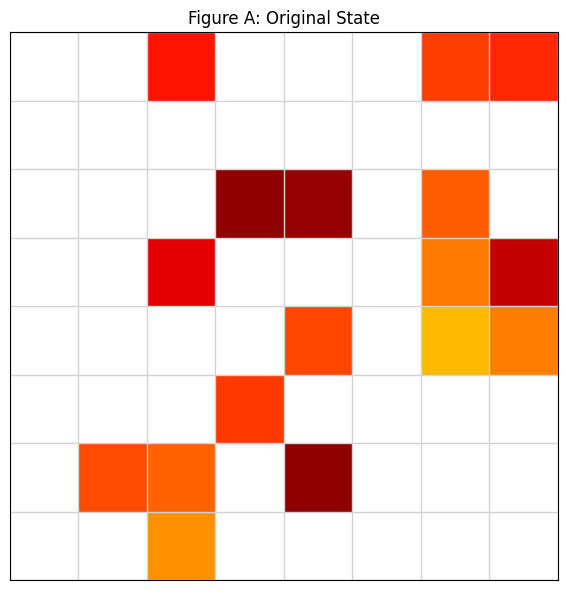

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 核心数据生成
# ==========================================
N = 8
num_pulses = 18
np.random.seed(42) # 固定种子

# 初始化两个全零矩阵
z1 = np.zeros((N, N))

# --- 关键：先随机确定“位置” (坐标) ---
# 这些坐标在两张图中必须完全一样
idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)

# --- 为图 A 赋值 ---
# 生成一组 15.0 ~ 20.0 的高数值 (显示为红/深橙色)
amps_A = np.random.uniform(15.0, 20.0, num_pulses)
z1[idx_x, idx_y] = amps_A

# 添加底噪 (不影响激活位置的视觉判断)
noise = np.random.normal(0, 0.5, z1.shape)
z1_final = z1 + noise

# ==========================================
# 2. 绘制图 A
# ==========================================
fig, ax = plt.subplots(figsize=(6, 6))

# 制作白底掩码 (隐藏噪声)
threshold = 5.0
z1_masked = np.ma.masked_where(z1_final < threshold, z1_final)

# 绘图
ax.imshow(z1_masked.T, cmap='jet', origin='lower', extent=[0, N, 0, N], vmin=0, vmax=20)

# 网格与样式设置
ax.set_xticks(np.arange(0, N + 1, 1))
ax.set_yticks(np.arange(0, N + 1, 1))
ax.grid(which='major', color='lightgray', linestyle='-', linewidth=1)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

plt.title("Figure A: Original State")
plt.tight_layout()
plt.show()

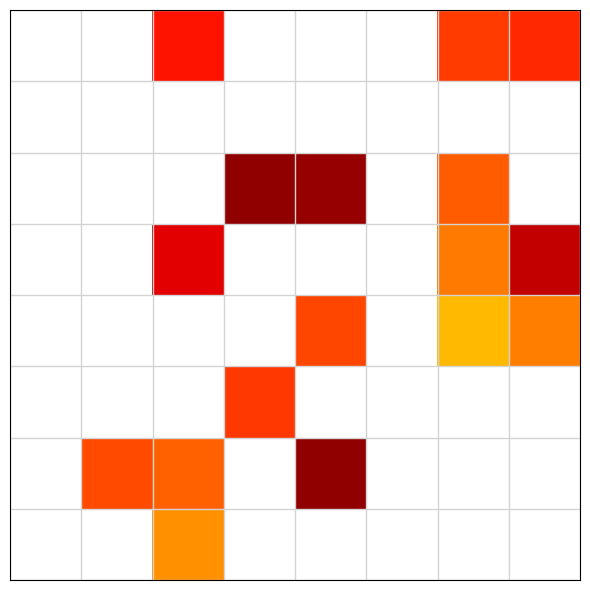

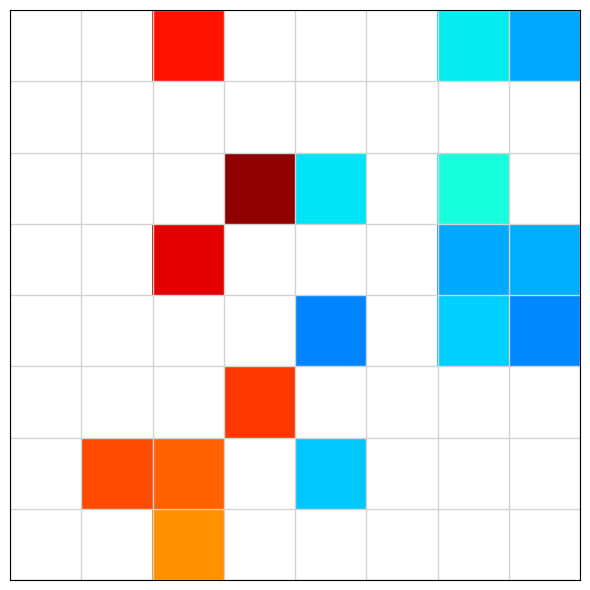

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 核心数据生成
# ==========================================
N = 8
num_pulses = 18
np.random.seed(42) # 固定种子

# 初始化两个全零矩阵
z1 = np.zeros((N, N))

# --- 关键：先随机确定“位置” (坐标) ---
# 这些坐标在两张图中必须完全一样
idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)

# --- 为图 A 赋值 ---
# 生成一组 15.0 ~ 20.0 的高数值 (显示为红/深橙色)
amps_A = np.random.uniform(15.0, 20.0, num_pulses)
z1[idx_x, idx_y] = amps_A

# 添加底噪 (不影响激活位置的视觉判断)
noise = np.random.normal(0, 0.5, z1.shape)
z1_final = z1 + noise

# ==========================================
# 2. 绘制图 A
# ==========================================
fig, ax = plt.subplots(figsize=(6, 6))

# 制作白底掩码 (隐藏噪声)
threshold = 5.0
z1_masked = np.ma.masked_where(z1_final < threshold, z1_final)

# 绘图
ax.imshow(z1_masked.T, cmap='jet', origin='lower', extent=[0, N, 0, N], vmin=0, vmax=20)

# 网格与样式设置
ax.set_xticks(np.arange(0, N + 1, 1))
ax.set_yticks(np.arange(0, N + 1, 1))
ax.grid(which='major', color='lightgray', linestyle='-', linewidth=1)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

#plt.title("Figure A: Original State")
plt.tight_layout()
plt.show()

# ==========================================
# 3. 生成图 B 数据 (基于图 A 修改)
# ==========================================
z2 = z1.copy() # 先复制，保证左半边和位置完全一样

# --- 关键逻辑：修改右半部分的“数值” ---
# 我们遍历之前的那些脉冲坐标
for i in range(num_pulses):
    current_x = idx_x[i]
    current_y = idx_y[i]
    
    # 如果脉冲位于右半边 (x >= 4)
    # 注意：因为绘图时用了 .T (转置)，这里的 x 对应屏幕上的横轴
    if current_x >= N // 2:
        # 修改数值：变成 5.0 ~ 8.0 (显示为蓝/青色)
        # 这预示着数值变小，或者符号发生了翻转
        new_val = np.random.uniform(5.0, 8.0)
        z2[current_x, current_y] = new_val

# 添加同样的噪声分布，保持背景质感一致
z2_final = z2 + noise

# ==========================================
# 4. 绘制图 B
# ==========================================
fig, ax = plt.subplots(figsize=(6, 6))

# 制作白底掩码
z2_masked = np.ma.masked_where(z2_final < threshold, z2_final)

# 绘图 (vmin/vmax 必须与图 A 保持一致，这样颜色变化才有意义)
ax.imshow(z2_masked.T, cmap='jet', origin='lower', extent=[0, N, 0, N], vmin=0, vmax=20)

# 网格与样式设置 (同上)
ax.set_xticks(np.arange(0, N + 1, 1))
ax.set_yticks(np.arange(0, N + 1, 1))
ax.grid(which='major', color='lightgray', linestyle='-', linewidth=1)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# (可选) 加一条红线辅助看分界
# ax.axvline(x=N//2, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


/Users/sixexamelben/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


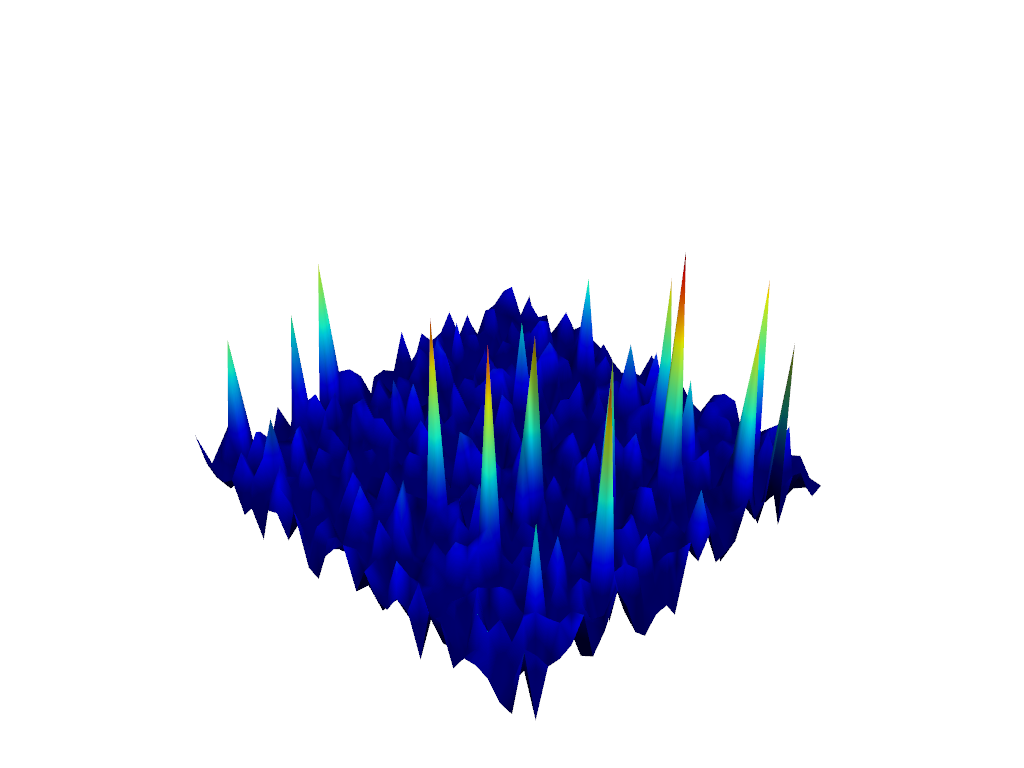

In [124]:
from __future__ import annotations
import numpy as np
import pyvista as pv

# 1. 生成数据
N = 32
xrng = np.linspace(0, N, N)
yrng = np.linspace(0, N, N)
x, y = np.meshgrid(xrng, yrng, indexing='ij')

# 初始化全0背景
z = np.zeros_like(x)

# --- 随机生成 10 个脉冲 ---
np.random.seed(42)
num_pulses = 20

idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)
amps = np.random.uniform(0.3, 1.0, num_pulses)

z[idx_x, idx_y] = amps

# --- 添加噪声 ---
noise = np.random.normal(0, 0.08, z.shape)
z = z + noise

# 放大数值
z_scaled = z * 20.0

# 2. 创建网格
grid = pv.StructuredGrid(x, y, z_scaled)

# 【关键修正】将 Z 数据绑定给网格，作为上色的依据 (Scalars)
# order='F' 是因为 VTK/PyVista 内部数据排列顺序的要求，与 meshgrid='ij' 对应
grid.point_data["height"] = z_scaled.flatten(order="F")

# 3. 绘图
grid.plot(
    show_axes=False,
    show_grid=False,
    show_edges=False,
    smooth_shading=True,
    # 这里的 clim 决定了颜色的映射范围
    clim=[0, 20], 
    show_scalar_bar=False,
    cmap='jet'  # 现在这个参数会生效了
)

展示：噪声背景下的中心与随机脉冲


/Users/sixexamelben/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


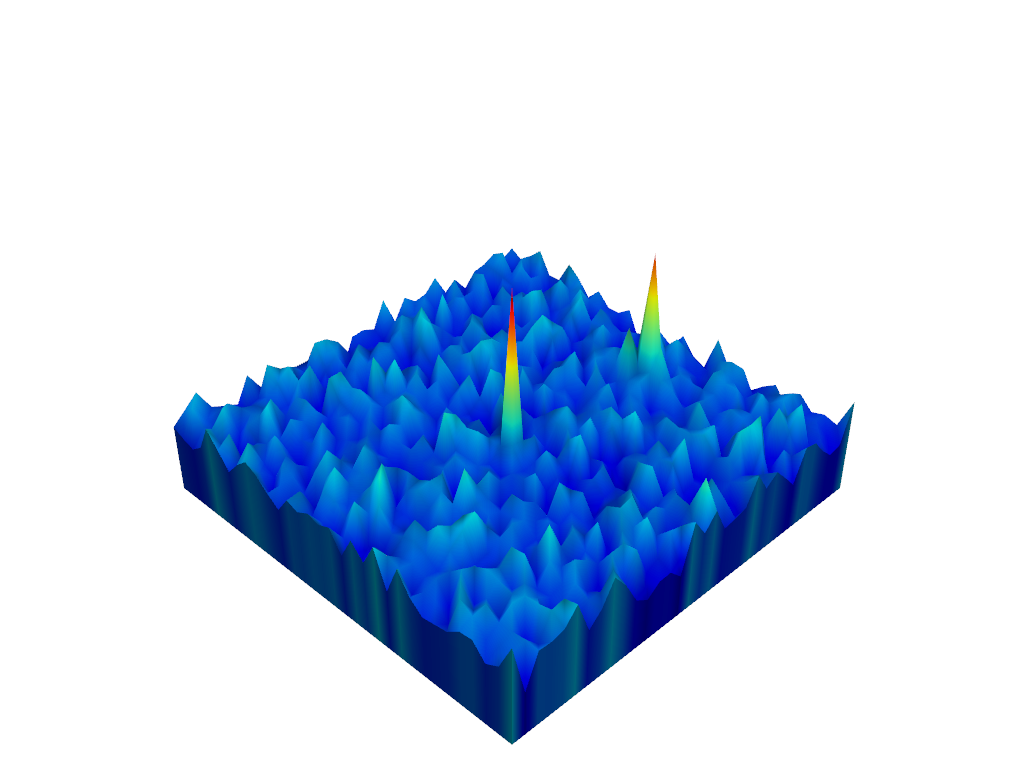

In [125]:
from __future__ import annotations
import numpy as np
import pyvista as pv

# 1. 生成数据
N = 32
xrng = np.linspace(0, N, N)
yrng = np.linspace(0, N, N)
x, y = np.meshgrid(xrng, yrng, indexing='ij')

# 初始化背景噪声 (大幅度噪声)
np.random.seed(42)
# 均值0，标准差1的噪声
noise = np.random.normal(0, 1.0, x.shape) 
z = noise.copy()

# --- 添加脉冲 (关键修改) ---
# 脉冲强度需要比噪声大，否则看不清，这里设为 5.0 (噪声标准差是1.0)
pulse_strength = 10.0

# 1. 中心位置脉冲
center = N // 2
z[center, center] += pulse_strength

# 2. 两个随机位置脉冲
rand_x = np.random.randint(0, N, 2)
rand_y = np.random.randint(0, N, 2)
z[rand_x, rand_y] += pulse_strength

# 3. 整体抬高
# 因为有负值的噪声，为了保证模型在基准面之上看起来自然，整体抬高
z_final = z + 5.0  

# ==========================================
# 构建厚重方块
# ==========================================

# 准备颜色数据 (Scalars)
scalars = z_final.flatten(order="F")

# 创建顶层网格
grid = pv.StructuredGrid(x, y, z_final)

top = grid.points.copy()
bottom = grid.points.copy()
bottom[:, -1] = -.5  # 设置底面绝对深度 (基准面)

vol = pv.StructuredGrid()
vol.points = np.vstack((top, bottom))
vol.dimensions = [*grid.dimensions[0:2], 2]

# 赋值颜色
vol.point_data["height"] = np.concatenate((scalars, scalars))

# 绘图
print("展示：噪声背景下的中心与随机脉冲")
vol.plot(
    show_axes=False,
    show_grid=False,
    show_edges=False, # 关掉网格线看杂乱感更强
    smooth_shading=True,
    clim=[np.min(z_final), np.max(z_final)], 
    show_scalar_bar=False,
    cmap='jet' 
)

展示：平缓信号


/Users/sixexamelben/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(
Context leak detected, msgtracer returned -1


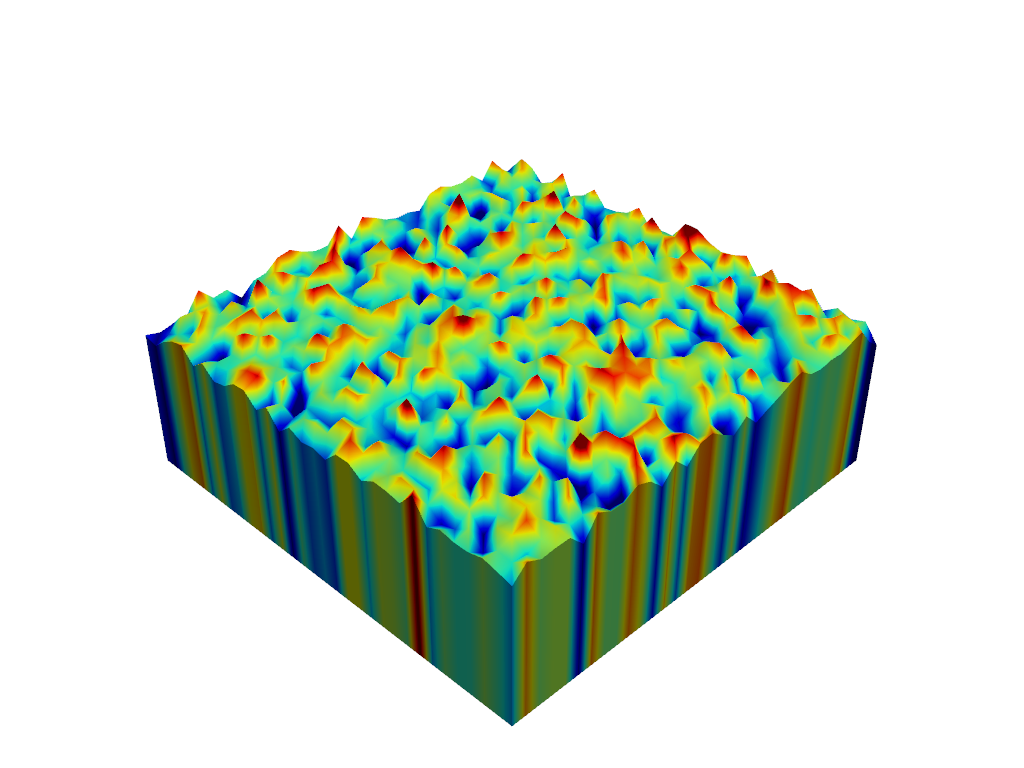

In [122]:
from __future__ import annotations
import numpy as np
import pyvista as pv

# 1. 生成数据
N = 32
xrng = np.linspace(0, N, N)
yrng = np.linspace(0, N, N)
x, y = np.meshgrid(xrng, yrng, indexing='ij')

# --- 生成平缓信号 ---
# 基础高度为 10
z = np.full_like(x, 10.0)

# 添加极微小的波动 (标准差 0.05)，让它看起来不那么“死板”，有点纹理
np.random.seed(123)
tiny_fluctuation = np.random.normal(0, 0.5, x.shape)
z_final = z + tiny_fluctuation

# ==========================================
# 构建厚重方块
# ==========================================

# 准备颜色数据
scalars = z_final.flatten(order="F")

# 创建顶层
grid = pv.StructuredGrid(x, y, z_final)

top = grid.points.copy()
bottom = grid.points.copy()
bottom[:, -1] = -.5 # 底面深度

vol = pv.StructuredGrid()
vol.points = np.vstack((top, bottom))
vol.dimensions = [*grid.dimensions[0:2], 2]

# 赋值颜色
vol.point_data["height"] = np.concatenate((scalars, scalars))

# 绘图
print("展示：平缓信号")
vol.plot(
    show_axes=False,
    show_grid=False,
    show_edges=False,
    smooth_shading=True,
    # 这里的 clim 可以设置得窄一点，或者直接用数据范围
    clim=[9.0, 11.0], 
    show_scalar_bar=False,
    cmap='jet' 
)

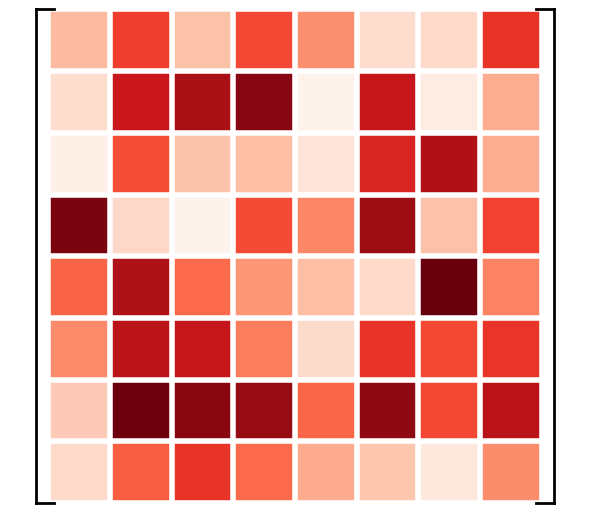

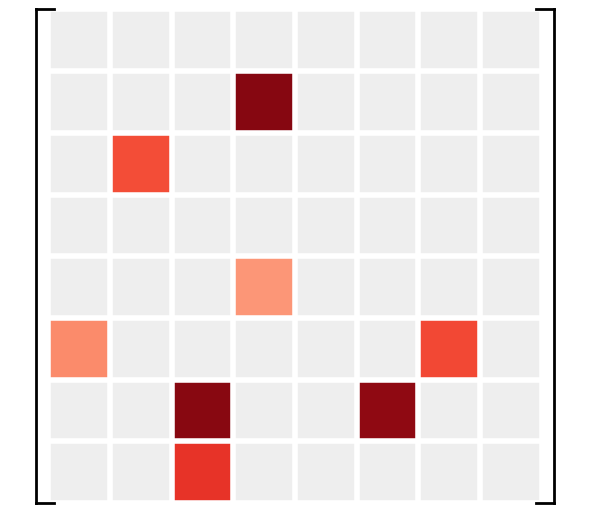

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ==========================================
# 辅助函数：绘制矩阵括号 []
# ==========================================
def draw_brackets(ax, N):
    bracket_color = 'black'
    bracket_width = 2.0
    offset = 0.2
    cap_len = 0.3

    # 左括号
    ax.plot([-offset, -offset], [0, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([-offset, -offset + cap_len], [N, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([-offset, -offset + cap_len], [0, 0], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)

    # 右括号
    ax.plot([N + offset, N + offset], [0, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([N + offset, N + offset - cap_len], [N, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([N + offset, N + offset - cap_len], [0, 0], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)

# ==========================================
# 通用绘图函数 (应用修复逻辑 + 绿色主题)
# ==========================================
def plot_clean_matrix(ax, data, vmin, vmax):
    N = data.shape[0]
    
    # 1. 添加局部灰色背景块
    rect = patches.Rectangle((0, 0), N, N, linewidth=0, facecolor='#EEEEEE', zorder=0)
    ax.add_patch(rect)
    
    # 2. 制作掩码 (对于稠密图，这里主要是为了统一接口，如果没有0值则无影响)
    # 对于稀疏图，这将隐藏0值，露出灰色背景
    z_masked = np.ma.masked_where(data == 0, data)
    
    # 3. 绘制数据 【关键修改：使用 'Greens' 色系】
    ax.imshow(z_masked.T, cmap='Purples', origin='lower', extent=[0, N, 0, N], vmin=vmin, vmax=vmax, zorder=1)
    
    # 4. 手动绘制白色网格线
    grid_width = 4
    for i in range(N + 1):
        ax.plot([0, N], [i, i], color='white', lw=grid_width, zorder=2)
        ax.plot([i, i], [0, N], color='white', lw=grid_width, zorder=2)
        
    # 5. 清除坐标轴和边框
    ax.axis('off')
    
    # 6. 绘制括号
    draw_brackets(ax, N)

# ==========================================
# 1. 生成数据：纯随机 (稠密)
# ==========================================
N = 8
np.random.seed(10020)
# 每个像素都在 0 到 20 之间独立随机
z_dense = np.random.uniform(0, 20, (N, N))

# ==========================================
# 2. 绘图：稠密图
# ==========================================
fig1, ax1 = plt.subplots(figsize=(6, 6))
plot_clean_matrix(ax1, z_dense, vmin=0, vmax=20)
plt.tight_layout()
plt.show()


# ==========================================
# 3. 处理数据：随机归零 (稀疏)
# ==========================================
np.random.seed(123) # 控制采样的位置

# 生成掩码：保留约 25% 的数据 (根据您提供的代码 < 0.25)
keep_mask = np.random.rand(N, N) < 0.25

# 应用掩码
z_sparse = np.zeros_like(z_dense)
z_sparse[keep_mask] = z_dense[keep_mask]

# ==========================================
# 4. 绘图：稀疏图
# ==========================================
fig2, ax2 = plt.subplots(figsize=(6, 6))
# 使用相同的绘图函数，它会自动处理0值掩码，显示灰色背景
plot_clean_matrix(ax2, z_sparse, vmin=0, vmax=20)
plt.tight_layout()
plt.show()

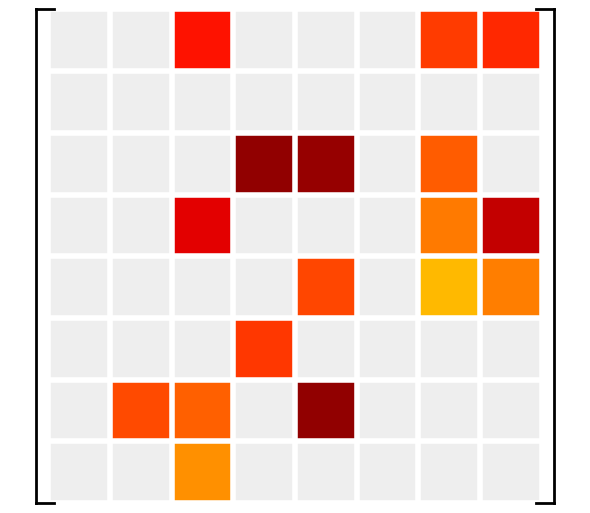

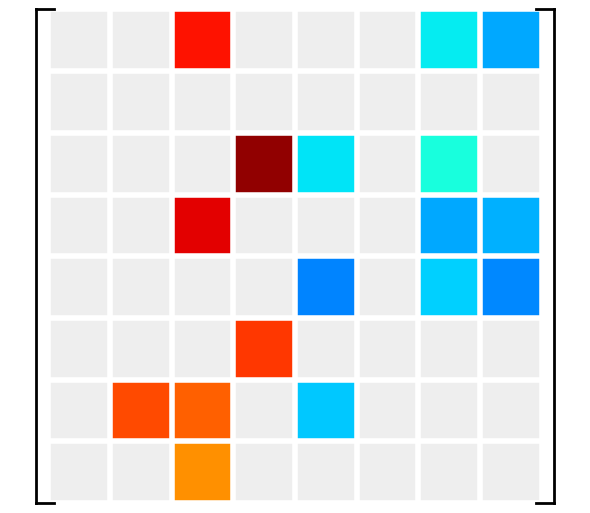

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ==========================================
# 辅助函数：绘制矩阵括号 []
# ==========================================
def draw_brackets(ax, N):
    bracket_color = 'black'
    bracket_width = 2.0
    offset = 0.2
    cap_len = 0.3

    # 左括号
    ax.plot([-offset, -offset], [0, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([-offset, -offset + cap_len], [N, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([-offset, -offset + cap_len], [0, 0], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)

    # 右括号
    ax.plot([N + offset, N + offset], [0, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([N + offset, N + offset - cap_len], [N, N], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)
    ax.plot([N + offset, N + offset - cap_len], [0, 0], color=bracket_color, lw=bracket_width, clip_on=False, zorder=10)

# ==========================================
# 通用绘图函数 (应用修复逻辑)
# ==========================================
def plot_clean_matrix(ax, data, title):
    N = data.shape[0]
    
    # 1. 【核心修复】手动添加灰色背景块
    # 只覆盖 (0,0) 到 (N,N) 的区域，不污染外部
    # zorder=0 确保它在最底层
    rect = patches.Rectangle((0, 0), N, N, linewidth=0, facecolor='#EEEEEE', zorder=0)
    ax.add_patch(rect)
    
    # 2. 制作掩码 (隐藏小于阈值的数据 -> 透明)
    threshold = 5.0
    z_masked = np.ma.masked_where(data < threshold, data)
    
    # 3. 绘制数据
    # zorder=1 确保数据在灰底之上
    ax.imshow(z_masked.T, cmap='jet', origin='lower', extent=[0, N, 0, N], vmin=0, vmax=20, zorder=1)
    
    # 4. 【核心修复】手动绘制白色网格线
    # 替代 ax.grid()，确保线条不伸出矩阵
    # zorder=2 确保白线压在数据和灰底之上
    grid_width = 4
    for i in range(N + 1):
        # 横线
        ax.plot([0, N], [i, i], color='white', lw=grid_width, zorder=2)
        # 竖线
        ax.plot([i, i], [0, N], color='white', lw=grid_width, zorder=2)
        
    # 5. 清除坐标轴和边框
    ax.axis('off') # 彻底关闭坐标轴，背景默认为白色
    
    # 6. 绘制括号
    draw_brackets(ax, N)
    
    #ax.set_title(title, y=-0.1) # 可选标题位置

# ==========================================
# 数据生成 (保持不变)
# ==========================================
N = 8
num_pulses = 18
np.random.seed(42) 

z1 = np.zeros((N, N))
idx_x = np.random.randint(0, N, num_pulses)
idx_y = np.random.randint(0, N, num_pulses)
amps_A = np.random.uniform(15.0, 20.0, num_pulses)
z1[idx_x, idx_y] = amps_A
noise = np.random.normal(0, 0.5, z1.shape)
z1_final = z1 + noise

# 生成图 B 数据
z2 = z1.copy()
for i in range(num_pulses):
    current_x = idx_x[i]
    current_y = idx_y[i]
    if current_x >= N // 2:
        new_val = np.random.uniform(5.0, 8.0)
        z2[current_x, current_y] = new_val
z2_final = z2 + noise

# ==========================================
# 执行绘图 (两张图分开画)
# ==========================================

# --- 图 A ---
fig1, ax1 = plt.subplots(figsize=(6, 6))
plot_clean_matrix(ax1, z1_final, "Figure A")
plt.tight_layout()
plt.show()

# --- 图 B ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
plot_clean_matrix(ax2, z2_final, "Figure B")
plt.tight_layout()
plt.show()